In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('NSL_KDD_bayesian_enc_training_set.csv')
test = pd.read_csv('NSL_KDD_bayesian_enc_testing_set.csv')

In [5]:
target = 'label'
IDcol = 'id'
train['label'].value_counts()

0    67343
1    58630
Name: label, dtype: int64

In [6]:
test['label'].value_counts()

1    12833
0     9711
Name: label, dtype: int64

In [7]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        n_estimators=cvresult.shape[0]
        alg.set_params(n_estimators=cvresult.shape[0])
        print(cvresult)
        print(n_estimators)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print(dtrain_predictions)
    print(dtrain_predprob )
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob))
    
#     Predict on testing data:
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['label'], dtest_predprob))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.991340       0.000205       0.991160      0.000676
1          0.996077       0.001795       0.996190      0.001514
2          0.997199       0.000877       0.997140      0.001009
3          0.998357       0.000339       0.998310      0.000308
4          0.998447       0.000328       0.998408      0.000343
..              ...            ...            ...           ...
598        0.999868       0.000203       1.000016      0.000045
599        0.999868       0.000204       1.000016      0.000045
600        0.999869       0.000204       1.000016      0.000046
601        0.999869       0.000203       1.000016      0.000045
602        0.999868       0.000204       1.000017      0.000046

[603 rows x 4 columns]
603


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0 0 1 ... 0 1 0]
[1.1349337e-03 2.2060341e-04 9.9999940e-01 ... 9.2483366e-05 9.9999654e-01
 8.1570988e-04]

Model Report
Accuracy : 0.9996
AUC Score (Train): 0.999999
AUC Score (Test): 0.965827


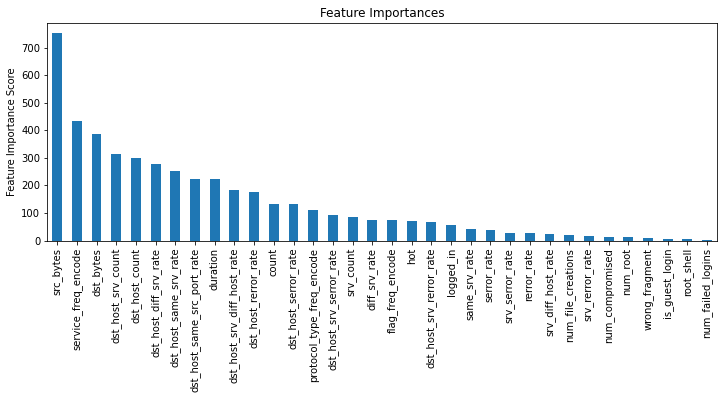

In [9]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=3000,
        max_depth=4,
        min_child_weight=6,
        gamma=0.3,
        alpha = 0.05,
        subsample=0.6,
        colsample_bytree=0.6,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)

In [10]:
# min_child_weight and max_depth
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators= 603, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([169.36708884, 170.19600081, 158.06039901, 241.36696577,
         245.08423142, 236.91074882, 404.71373248, 358.81667681,
         310.23009987, 360.22991357, 336.08724742, 280.71265383]),
  'std_fit_time': array([ 4.14003081,  3.22534063,  4.65962702,  6.9892733 ,  2.58819733,
          4.16737665, 66.6025105 , 48.86673129,  7.41090888, 11.07030752,
          6.68796344, 27.4592244 ]),
  'mean_score_time': array([0.30430689, 0.25169835, 0.25449619, 0.36381712, 0.39537592,
         0.42960753, 0.55800924, 0.50355988, 0.47489982, 0.49037004,
         0.46966748, 0.38533583]),
  'std_score_time': array([0.03872268, 0.03177877, 0.02632786, 0.02837657, 0.03421958,
         0.02119136, 0.10544988, 0.03673496, 0.04358513, 0.07137611,
         0.02785442, 0.04965163]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False]

In [11]:
# min_child_weight and max_depth
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=603, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:21:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([208.31174731, 202.71383224, 202.64588351, 244.11746106,
         243.16691074, 240.53011732, 278.83017521, 272.92029967,
         234.07625279]),
  'std_fit_time': array([ 3.09908227,  2.77849851,  1.10255152,  0.69732887,  0.4341785 ,
          0.62343744,  1.15274247,  1.92408085, 60.78966933]),
  'mean_score_time': array([0.42449193, 0.41518574, 0.42382193, 0.47109923, 0.45217042,
         0.44202442, 0.45276246, 0.46620831, 0.37620263]),
  'std_score_time': array([0.04577842, 0.06153136, 0.04742517, 0.07554594, 0.04722687,
         0.06443904, 0.02719207, 0.03207424, 0.06440561]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
  

In [12]:
# min_child_weight
param_test2b = {'min_child_weight':[6,8,10,12]}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=603, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2b.fit(train[predictors],train[target])
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([227.42040682, 225.18006368, 223.12119327, 221.9419127 ]),
  'std_fit_time': array([1.11828453, 1.34449483, 0.73881404, 0.47956428]),
  'mean_score_time': array([0.3911943 , 0.3953784 , 0.41385889, 0.47495666]),
  'std_score_time': array([0.02738747, 0.05669411, 0.06507194, 0.05927596]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.99998633, 0.99998935, 0.99998442, 0.9999831 ]),
  'split1_test_score': array([0.99999355, 0.99999202, 0.99999195, 0.99998883]),
  'split2_test_score': array([0.99998724, 0.99998635, 0.99998206, 0.9999806 ]),
  'split3_test_score': array([0.99999678, 0.99999595, 0.99999562, 0.99999447]),
  'split4_test_score': array([0.99999268, 0.99999457, 0.99999392, 0.9999941

In [14]:
# gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=603, max_depth=5,
 min_child_weight=8, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:44:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([225.37248974, 222.1102087 , 221.5993495 , 221.2957243 ,
         193.49137855]),
  'std_fit_time': array([ 3.98045361,  0.34136571,  0.78647731,  0.64919317, 56.93869441]),
  'mean_score_time': array([0.33122616, 0.37114401, 0.32497735, 0.32395916, 0.29685111]),
  'std_score_time': array([0.01822078, 0.05706875, 0.03336292, 0.02863919, 0.04419758]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.99998935, 0.999986  , 0.99998697, 0.99998523, 0.99998437]),
  'split1_test_score': array([0.99999202, 0.99999175, 0.99999145, 0.99999219, 0.99999146]),
  'split2_test_score': array([0.99998635, 0.99998542, 0.99998557, 0.99998666, 0.99998604]),
  'split3_test_score': array([0.99999595, 0.99999618, 0.9999962 , 0

In [15]:
# subsample and colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=603, max_depth=5,
 min_child_weight=8, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:58:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([189.50409503, 188.61341105, 186.32352228, 182.13163977,
         207.8616931 , 205.5847281 , 205.36351767, 202.54493461,
         228.76227107, 226.01648502, 223.62532473, 220.75995641,
         247.68700514, 247.5695364 , 243.4343257 , 235.95978117]),
  'std_fit_time': array([1.12909112, 0.50440916, 2.56247313, 1.42420256, 0.88316265,
         1.65347599, 0.83081382, 1.77299501, 1.25877387, 1.39431509,
         1.63994042, 1.1983165 , 0.57939829, 1.87928023, 3.13087055,
         4.5352928 ]),
  'mean_score_time': array([0.52238021, 0.42365193, 0.52128754, 0.34060283, 0.36560068,
         0.33747892, 0.36245737, 0.3474401 , 0.37008376, 0.34287276,
         0.35791483, 0.33696718, 0.39180851, 0.35811357, 0.36568723,
         0.31518235]),
  'std_score_time': array([0.14232816, 0.05911084, 0.1530995 , 0.04121914, 0.07628571,
         0.02538287, 0.04659786, 0.02231013, 0.00887819, 0.04744752,
         0.02728391, 0.01524947, 0.0325636 , 0.01613649, 0.02774961,
 

In [16]:
# subsample and colsample_bytree
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=603, max_depth=5,
 min_child_weight=8, gamma=0.0, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,cv=5)
gsearch5.fit(train[predictors],train[target])

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:44:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6,
                                     enable_categorical=False, gamma=0.0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=8,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=603, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weig

In [17]:
# alpha (regularization paramter)
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=603, max_depth=5,
 min_child_weight=8, gamma=0.0, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:06:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'mean_fit_time': array([182.85693774, 181.69779124, 181.84177737, 181.58236437,
         156.37522383]),
  'std_fit_time': array([ 0.89851205,  0.61322181,  0.53558616,  0.85056142, 47.50580444]),
  'mean_score_time': array([0.36247568, 0.37564421, 0.34685144, 0.32185311, 0.29060373]),
  'std_score_time': array([0.0507714 , 0.0718996 , 0.04780051, 0.03217121, 0.02897773]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'split0_test_score': array([0.99999116, 0.99999158, 0.99999133, 0.99999134, 0.99999051]),
  'split1_test_score': array([0.99999417, 0.99999402, 0.99999414, 0.9999943 , 0.99999383]),
  'split2_test_score': array([0.99998842, 0.99998854, 0.99999034, 0.99998883, 0.9999873 ]),
  'split3_test_score': array([0.999

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.995490       0.000330       0.995352      0.000366
1          0.998531       0.000382       0.998407      0.000481
2          0.998692       0.000435       0.998609      0.000562
3          0.999128       0.000319       0.999136      0.000321
4          0.999318       0.000068       0.999314      0.000096
..              ...            ...            ...           ...
376        0.999877       0.000182       1.000017      0.000043
377        0.999876       0.000182       1.000018      0.000043
378        0.999876       0.000182       1.000018      0.000043
379        0.999876       0.000182       1.000018      0.000043
380        0.999876       0.000184       1.000018      0.000043

[381 rows x 4 columns]
381


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0 0 1 ... 0 1 0]
[1.5477807e-03 3.2944718e-04 9.9999881e-01 ... 1.6927447e-04 9.9999690e-01
 6.7964662e-04]

Model Report
Accuracy : 0.9996
AUC Score (Train): 0.999999
AUC Score (Test): 0.970261


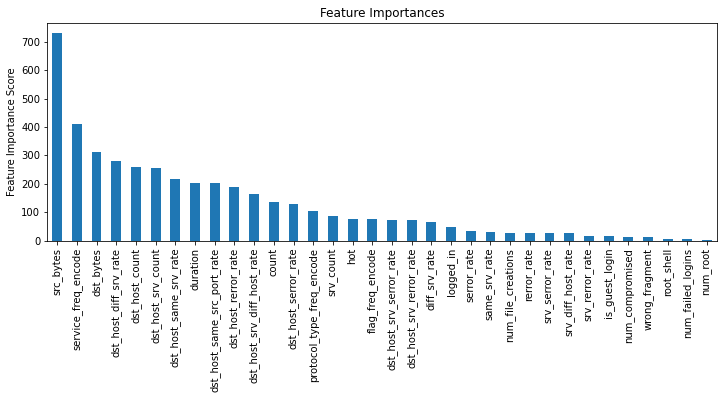

In [18]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=603,
        max_depth=5,
        min_child_weight=8,
        gamma=0.0,
        reg_alpha = 0.005,
        subsample=0.9,
        colsample_bytree=0.6,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.995490       0.000330       0.995352      0.000366
1          0.998531       0.000382       0.998407      0.000481
2          0.998692       0.000435       0.998609      0.000562
3          0.999128       0.000319       0.999136      0.000321
4          0.999318       0.000068       0.999314      0.000096
..              ...            ...            ...           ...
376        0.999877       0.000182       1.000017      0.000043
377        0.999876       0.000182       1.000018      0.000043
378        0.999876       0.000182       1.000018      0.000043
379        0.999876       0.000182       1.000018      0.000043
380        0.999876       0.000184       1.000018      0.000043

[381 rows x 4 columns]
381


C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0 0 1 ... 0 1 0]
[1.5477807e-03 3.2944718e-04 9.9999881e-01 ... 1.6927447e-04 9.9999690e-01
 6.7964662e-04]

Model Report
Accuracy : 0.9996
AUC Score (Train): 0.999999
AUC Score (Test): 0.970261


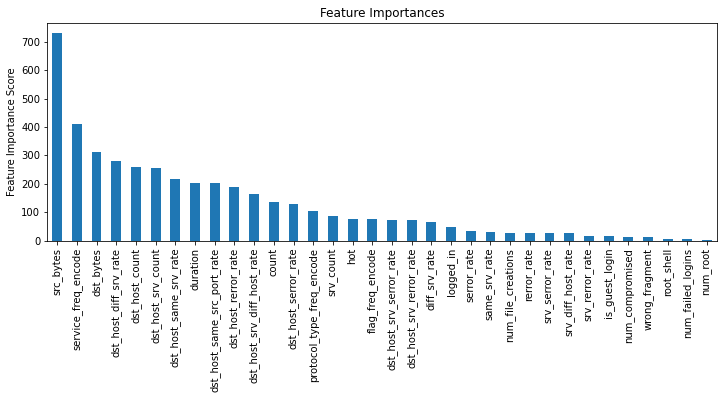

In [19]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=381,
        max_depth=5,
        min_child_weight=8,
        gamma=0.0,
        reg_alpha = 0.005,
        subsample=0.9,
        colsample_bytree=0.6,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)